In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.special import roots_laguerre
from scipy.integrate import quad
from math import factorial

import signature.tensor_algebra as ta
from signature.ode_integration import *

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color= ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"])

## 1. Looking at the function $f(z) = \mathbb{E}[\exp(-(z + W_T)^4)],\ z \in \mathbb{C}$

Fix $T = 0.05$

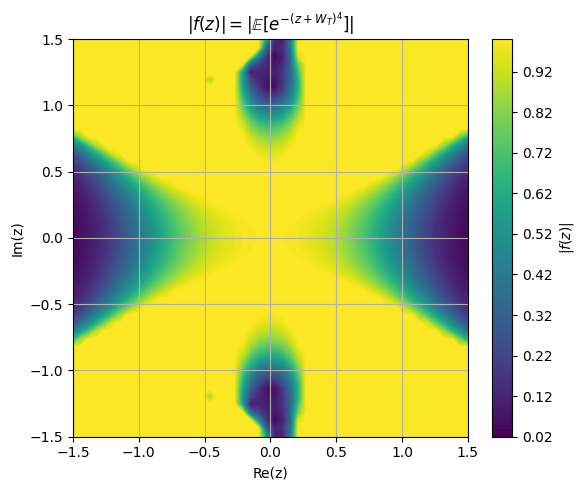

In [2]:
# Parameters
T = 0.05          # time horizon
R = 1.5          # radius in complex plane
N = 50         # grid size
MC_samples = 100000  # Monte Carlo samples

# Monte Carlo samples of W_T ~ N(0, T)
W = np.random.normal(0, np.sqrt(T), size=MC_samples)

# Grid in complex plane
x = np.linspace(-R, R, N)
y = np.linspace(-R, R, N)
X, Y = np.meshgrid(x, y)
Z = X + 1j*Y

# Monte Carlo estimate of f(z)
def f_mc(z):
    vals = np.exp(-(z + W)**4)
    return np.mean(vals)

# Vectorize
f_vec = np.vectorize(f_mc)

# Compute |f(z)| on grid
F = f_vec(Z)
F_abs = np.minimum(np.abs(F), 1)

# Plot
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, F_abs, levels=100, cmap="viridis")
plt.colorbar(label=r"$|f(z)|$")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.title(r"$|f(z)| = |\mathbb{E}[e^{-(z+W_T)^4}]|$")
plt.show()


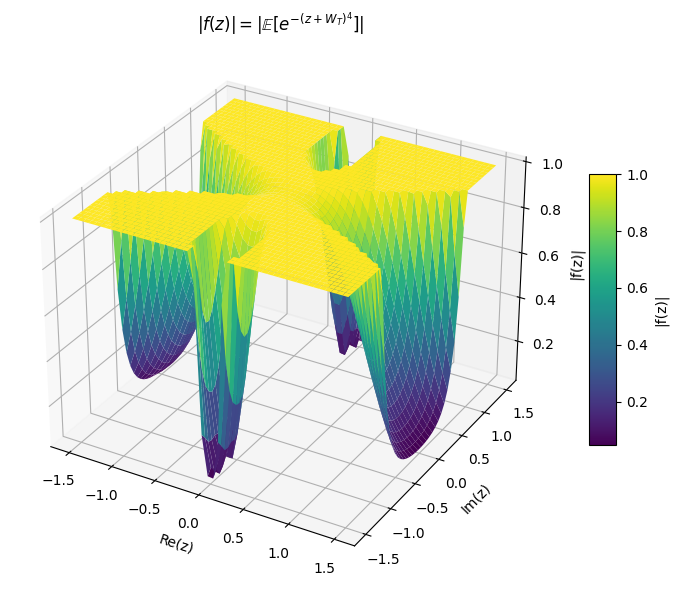

In [3]:
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, np.minimum(F_abs, 1), cmap="viridis", edgecolor="none")

ax.set_xlabel("Re(z)")
ax.set_ylabel("Im(z)")
ax.set_zlabel("|f(z)|")
ax.set_title(r"$|f(z)| = |\mathbb{E}[e^{-(z+W_T)^4}]|$")

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="|f(z)|")

plt.show()

Zeros on $\Im(z) = 0$? Fix $z = ix$ and rewrite
$$
f(ix) = \mathbb{E}[\exp(-W_T^4 + 6x^2W_T^2 - x^4)\cos(4x^3W_T - 4xW_T^3))]
$$

In [4]:
# variance T
T = 0.05          # time horizon
sigma = np.sqrt(T)

# integrand for quadrature
def integrand(w, x):
    px = np.exp(-w**2/(2*sigma**2) - w**4 + 6*(x**2)*(w**2) - x**4) / (np.sqrt(2*np.pi)*sigma)
    phi = 4*(x**3)*w - 4*x*(w**3)
    return px * np.cos(phi)

def g_quadrature(x):
    val, _ = quad(lambda w: integrand(w, x), -np.inf, np.inf, epsabs=1e-10, epsrel=1e-10, limit=200)
    return val

# Monte Carlo estimate
def g_mc(x, N=1000000, seed=0):
    rng = np.random.default_rng(seed)
    W = rng.normal(0, sigma, N)
    vals = np.exp(-W**4 + 6*(x**2)*(W**2) - x**4) * np.cos(4*(x**3)*W - 4*x*(W**3))
    return vals.mean()

# grid of x
xs = np.linspace(0, 1.5, 1000)
gq = [g_quadrature(x) for x in xs]
gmc = [g_mc(x, N=200000) for x in xs]

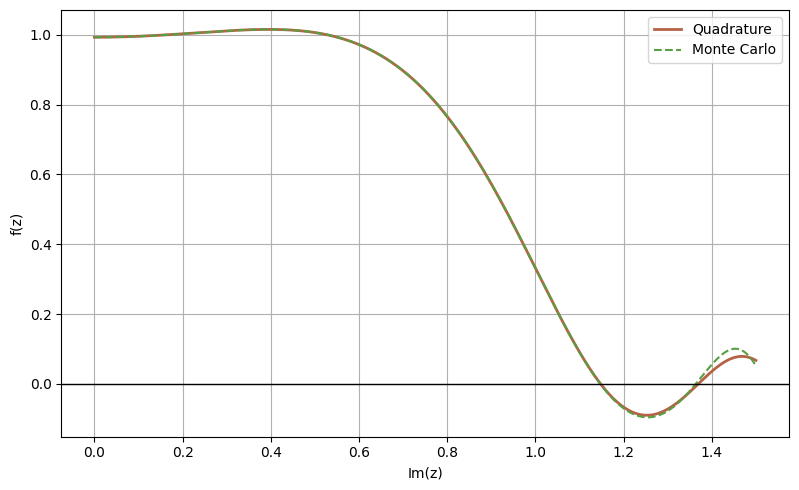

In [6]:
# plot
fig, ax = plt.subplots()
ax.plot(xs, gq, label="Quadrature", lw=2)
ax.plot(xs, gmc, '--', label="Monte Carlo")
ax.axhline(0, color="k", lw=1)
ax.set_xlabel("Im(z)")
ax.set_ylabel("f(z)")
ax.legend()
plt.show()

fig.tight_layout()
fig.savefig("images/riccati_zeros/zeros_imag_line.pdf", format="pdf", transparent=True)

In [7]:
xs[np.abs(gq) <= 0.001]

array([1.14714715, 1.36936937])

In [8]:
R = xs[np.abs(gq) <= 0.001][0]
R

1.147147147147147

### First zero at $R \approx 1.15$... Let's solve the Riccati equation

In [4]:
T = 0.18

In [5]:
N = 19
dim = 1
e = ta.AlgebraBasis(dim=dim, trunc=N)

#### Laplace transform Via MC

In [6]:
u_coef = -24
pol = lambda x: u_coef * (x**4 / 24)

In [7]:
rng = np.random.default_rng(seed=42)
n_sample = 10**6
W_T = rng.normal(size=n_sample) * np.sqrt(T)
sample = np.exp(pol(W_T))
sample.mean(), sample.std() / np.sqrt(n_sample)

(0.9323020249921101, 0.00014645462252730864)

#### Via quadratures

In [50]:
N_points = 150

z_arr, w_arr = roots_laguerre(n=N_points)

def f(x):
    return np.exp(pol(np.sqrt(T) * x[None, :]) - 0.5 * x[None, :]**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f(z_arr) @ (w_arr * np.exp(z_arr))
cf_quad[-1]

0.932427292420342

#### Via inf-dimensional Riccati

In [12]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=dim)
args = {"shuffle_table": shuffle_table}

In [13]:
@jax.jit
def ode_fun(psi: ta.TensorSequence, args: dict) -> ta.TensorSequence:
    return psi.proj(11) * 0.5 + ta.shuffle_pow(psi.proj(1), 2, args["shuffle_table"]) * 0.5

In [53]:
for n in [2, 10, 30, 50, 75, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]:
    u_trunc = N
    t_grid = np.linspace(0, T, n)
    u = ta.from_word(1111, trunc=u_trunc, dim=1) * (u_coef)

    step_fun = step_fun_pece # step_fun_euler

    psi = ode_solver_traj(fun=ode_fun, step_fun=step_fun, t_grid=t_grid, init=u, args=args)
    psi_T = psi.subsequence([-1,])
    print(np.exp(psi_T[0]), np.abs(np.exp(psi_T[0]) - cf_quad[-1]))
    # ta.plot_coefficients(psi_T, nonzero=True, ax=ax)

0.907374513081956 0.0250527793383859
0.9329057325287687 0.00047844010842679197
0.9346291457009867 0.0022018532806447055
0.9351909664755254 0.002763674055183407
0.9355833202223472 0.003156027802005301
0.9358298594182834 0.003402566997941503
0.9362932915832244 0.0038659991628824386
0.9366120280346621 0.004184735614320201
0.9366973315240202 0.004270039103678291
0.9367247361104041 0.0042974436900621305
0.9367333888959545 0.004306096475612531
0.9367346953795926 0.004307402959250695
0.9367350278323711 0.004307735412029112
0.9367351217312659 0.004307829310923994


NameError: name 'psi_T' is not defined

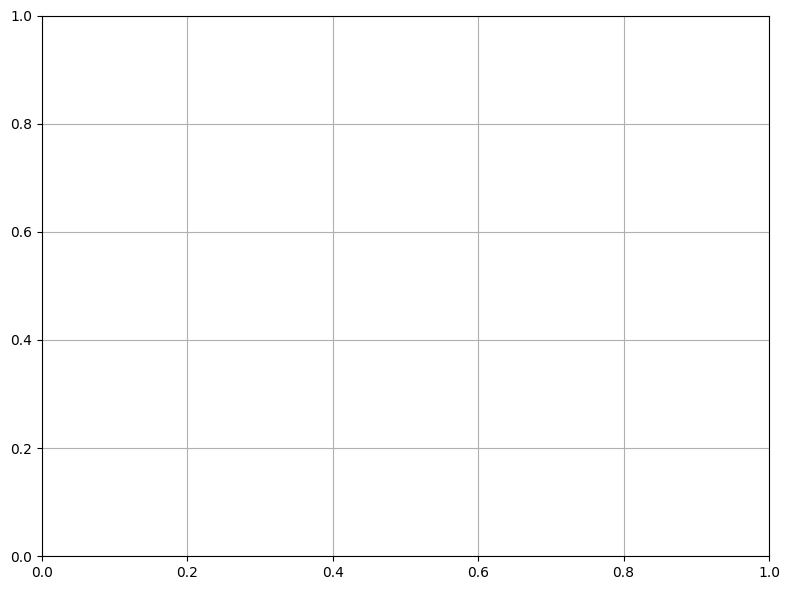

In [14]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cmap = plt.cm.plasma

r = 2
N_x_grid = 1000
x_grid = np.linspace(-r, r, N_x_grid)
factorials = np.array([factorial(i) for i in range(N + 1)])
x_arr = (x_grid[None, :] ** np.arange(N + 1)[:, None]) / factorials[:, None]

fig, ax = plt.subplots(figsize=(8, 6))

L = len(np.arange(5, N+1))
for i, trunc in enumerate(np.arange(5, N+1)):
    ax.plot(x_grid, np.real(psi_T.array[:trunc + 1] @ x_arr[:trunc + 1]), label=f"M = {trunc}", color=cmap(norm(i / L)))
ax.set_xlabel("x")

y_lim_1, y_lim_2 = -10, 10

ax.vlines(R, y_lim_1, y_lim_2, "k", label="$r_t$")
ax.vlines(-R, y_lim_1, y_lim_2, "k")

ax.set_ylim([y_lim_1, y_lim_2])
ax.legend()

fig.tight_layout()
plt.savefig("images/riccati_zeros/psi_series.pdf", format="pdf", transparent=True)

### Testing the Cauchy-Hadamard criterion

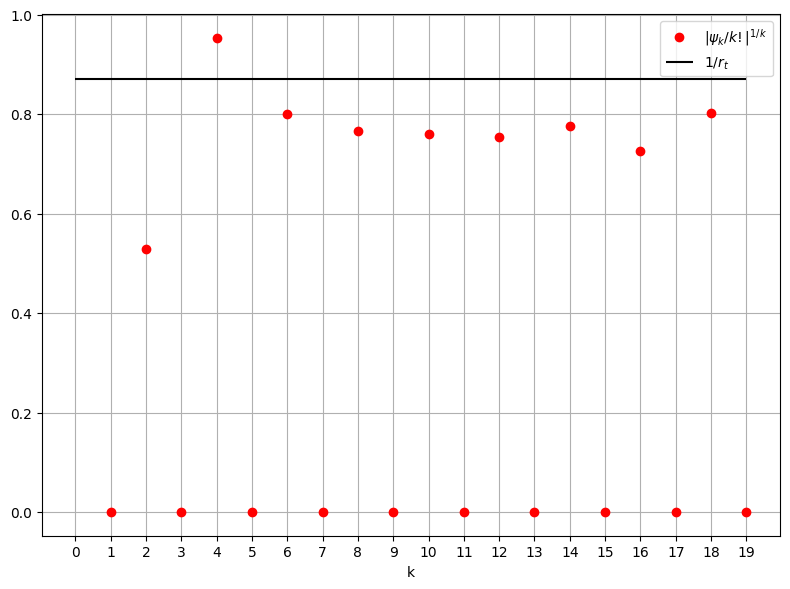

In [18]:
ii = np.arange(N + 1)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(ii[1:], np.abs(psi_T.array / factorials)[1:]**(1 / ii[1:]), "ro", label="$|\psi_k / k!|^{1/k}$")
ax.hlines(1 / 1.15, 0, np.max(ii), "k", label="$1 / r_t$")
ax.set_xlabel("k")
ax.legend()
ax.set_xticks(np.arange(N + 1))
plt.show()

fig.tight_layout()
fig.savefig("images/riccati_zeros/cauchy-hadamard.pdf", format="pdf", transparent=True)

# Comparing different methods: Riccati, Centered Riccati, Monte Carlo

In [16]:
T = 0.05          # time horizon
N = 19
dim = 1
e = ta.AlgebraBasis(dim=dim, trunc=N)
R = 1.147147147147147

r = 2
N_x_grid = 100
x_grid = np.linspace(-r, r, N_x_grid)

#### Via MC

In [6]:
u_coef = -24
pol = lambda x: u_coef * (x**4 / 24)

In [8]:
rng = np.random.default_rng(seed=42)
n_sample = 10**6
W_T = rng.normal(size=n_sample) * np.sqrt(T)
sample = np.exp(pol(x_grid[None, :] + W_T[:, None]))
cf_mc = sample.mean(axis=0)

#### Via inf-dimensional Riccati

In [11]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=dim)
args = {"shuffle_table": shuffle_table}

In [12]:
@jax.jit
def ode_fun(psi: ta.TensorSequence, args: dict) -> ta.TensorSequence:
    return psi.proj(11) * 0.5 + ta.shuffle_pow(psi.proj(1), 2, args["shuffle_table"]) * 0.5

In [13]:
u_trunc = N
n = 1000
t_grid = np.linspace(0, T, n)
u = ta.from_word(1111, trunc=u_trunc, dim=1) * (u_coef)

In [14]:
# fig, ax = plt.subplots(figsize=(12, 6))

step_fun = step_fun_pece # step_fun_euler

psi = ode_solver_traj(fun=ode_fun, step_fun=step_fun, t_grid=t_grid, init=u, args=args)
psi_T = psi.subsequence([-1,])
print(np.exp(psi_T[0]))
# ta.plot_coefficients(psi_T, nonzero=True, ax=ax)

0.9928039072775828


#### Centered inf-dimensional Riccati

In [17]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=dim)
args = {"shuffle_table": shuffle_table}

In [18]:
u_trunc = N
n = 1000
t_grid = np.linspace(0, T, n)
u = ta.from_word(1111, trunc=u_trunc, dim=1) * (u_coef)

In [19]:
dim_sig = ta.number_of_words_up_to_trunc(dim=dim, trunc=N)
proj_mat = np.zeros((dim_sig, dim_sig))

for i in range(dim_sig):
    v = ta.index_to_word(i, dim)
    proj_mat[i] = u.proj(v).array

In [20]:
factorials = np.array([factorial(i) for i in range(N + 1)])
x_arr = (x_grid[None, :] ** np.arange(N + 1)[:, None]) / factorials[:, None]
u_left_proj_x_arr = x_arr.T @ proj_mat.T

In [21]:
proj_mat

array([[ -0.,  -0.,  -0.,  -0., -24.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,
         -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.],
       [ -0.,  -0.,  -0., -24.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,
         -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,   0.],
       [ -0.,  -0., -24.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,
         -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,   0.,   0.],
       [ -0., -24.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,
         -0.,  -0.,  -0.,  -0.,  -0.,  -0.,   0.,   0.,   0.],
       [-24.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,
         -0.,  -0.,  -0.,  -0.,  -0.,   0.,   0.,   0.,   0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,
         -0.,  -0.,  -0.,  -0.,   0.,   0.,   0.,   0.,   0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,  -0.,
         -0.,  -0.,  -0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.,  -0

In [19]:
@jax.jit
def ode_fun(psi: ta.TensorSequence, args: dict) -> ta.TensorSequence:
    return psi.proj(11) * 0.5 + ta.shuffle_pow(psi.proj(1), 2, args["shuffle_table"]) * 0.5

In [20]:
psi_centered_arr = np.zeros_like(x_grid)

for i, u_x in enumerate(u_left_proj_x_arr):
    u_left_proj_x = ta.from_array(u_x, N, dim)
    step_fun = step_fun_pece # step_fun_euler

    psi_centered = ode_solver_traj(fun=ode_fun, step_fun=step_fun, t_grid=t_grid, init=u_left_proj_x, args=args)
    psi_T_centered = psi_centered.subsequence([-1,])
    psi_centered_arr[i] = psi_T_centered[0]

#### Plotting all the results

In [22]:
shuffle_exp_psi = ta.shuffle_exp(psi_T, shuffle_table)

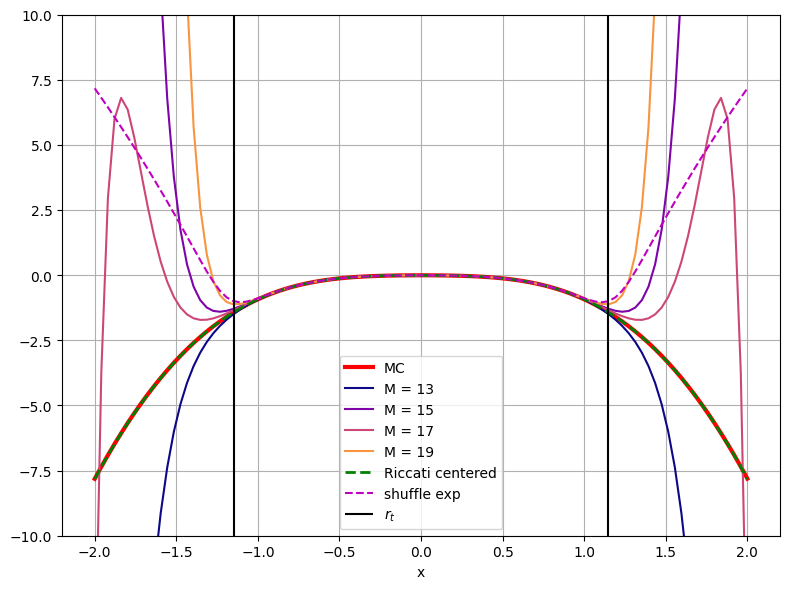

In [26]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cmap = plt.cm.plasma

factorials = np.array([factorial(i) for i in range(N + 1)])
x_arr = (x_grid[None, :] ** np.arange(N + 1)[:, None]) / factorials[:, None]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_grid, np.log(cf_mc), "r", label="MC", lw=3)

ran = np.arange(N-6, N+1, 2)
L = len(ran)
for i, trunc in enumerate(ran):
    ax.plot(x_grid, np.real(psi_T.array[:trunc + 1] @ x_arr[:trunc + 1]), label=f"M = {trunc}", color=cmap(norm(i / L)))
ax.set_xlabel("x")

ax.plot(x_grid, psi_centered_arr, "g--", label="Riccati centered", lw=2)

ax.plot(x_grid, np.log(shuffle_exp_psi.array @ x_arr), "m--", label="shuffle exp")

y_lim_1, y_lim_2 = -10, 10

ax.vlines(R, y_lim_1, y_lim_2, "k", label="$r_t$")
ax.vlines(-R, y_lim_1, y_lim_2, "k")

ax.set_ylim([y_lim_1, y_lim_2])
ax.legend()

fig.tight_layout()
plt.savefig("images/riccati_zeros/psi_series.pdf", format="pdf", transparent=True)